In [5]:
# Listing all the fields
from mp_api.client import MPRester
from secretInfo import APIKEY

with MPRester(APIKEY) as mpr:
    fields = mpr.materials.summary.available_fields
    print(fields)

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic',

In [6]:
from mp_api.client import MPRester
import pandas as pd
from secretInfo import APIKEY  # your API key module

# Define the fields to pull
fields = [
    "material_id",
    "formula_pretty",
    "elements",
    "nelements",
    "band_gap",
    "density",
    "formation_energy_per_atom",
    "energy_above_hull",
    "bulk_modulus",
    "shear_modulus",
    "volume",
    "nsites",
    "total_magnetization",
    "structure"
]


# Connect to the Materials Project API
with MPRester(APIKEY) as mpr:
    docs = mpr.materials.summary.search(
        fields=fields,
        num_chunks=100  # pull more than one page of results
    )

# Convert to dictionary list for DataFrame creation
materials_data = [
    {
        "material_id": d.material_id,
        "formula": d.formula_pretty,
        "elements": d.elements,
        "nelements": d.nelements,
        "band_gap": d.band_gap,
        "formation_energy_per_atom": d.formation_energy_per_atom,
        "bulk_modulus": getattr(d, "bulk_modulus", None),
        "shear_modulus": getattr(d, "shear_modulus", None),
        "density": d.density,
        "energy_above_hull": d.energy_above_hull,
        "volume": d.volume,
        "nsites": d.nsites,
        "total_magnetization": getattr(d, "total_magnetization", None)
    }
    for d in docs
]


# Load into a DataFrame
df = pd.DataFrame(materials_data)

Retrieving SummaryDoc documents: 100%|██████████| 100000/100000 [01:20<00:00, 1243.82it/s]


In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

def extract_modulus_value(x):
    """Extract modulus value in order: voigt → vrh → reuss."""
    if isinstance(x, dict):
        return x.get('voigt') or x.get('vrh') or x.get('reuss')
    return np.nan  # Ensures missing values are caught

def clean_and_impute_material_data(df, use_knn=True):
    # ---- Step 1: Extract numeric values from complex modulus fields ----
    df['shear_modulus_final'] = df['shear_modulus'].apply(extract_modulus_value)
    df['bulk_modulus_final'] = df['bulk_modulus'].apply(extract_modulus_value)

    # ---- Step 2: Define all required features for modeling ----
    required_features = [
        'band_gap',
        'formation_energy_per_atom',
        'bulk_modulus_final',
        'shear_modulus_final',
        'density',
        'volume',
        'total_magnetization',
        'energy_above_hull',
        'nsites'
    ]

    # ---- Step 3: Check missing values before cleaning ----
    print("\nMissing values BEFORE cleaning:")
    print(df[required_features].isnull().sum())

    if use_knn:
        # ---- Step 4a: KNN Imputation ----
        knn_imputer = KNNImputer(n_neighbors=5)
        imputed_array = knn_imputer.fit_transform(df[required_features])
        df[required_features] = pd.DataFrame(imputed_array, columns=required_features, index=df.index)
        print("\nKNN Imputation applied.")
    else:
        # ---- Step 4b: Strict Cleaning (Drop rows with missing values) ----
        df = df.dropna(subset=required_features)
        print("\nRows dropped with missing critical values.")

    # ---- Step 5: Report missing values after cleaning/imputation ----
    print("\nMissing values AFTER cleaning/imputation:")
    print(df[required_features].isnull().sum())

    # ---- Optional: Drop original complex columns ----
    df = df.drop(columns=['bulk_modulus', 'shear_modulus'], errors='ignore')

    return df


In [8]:
knn_features = [
    'energy_above_hull', 'total_magnetization',
    'shear_modulus_final', 'bulk_modulus_final'
]

df_cleaned = clean_and_impute_material_data(df, use_knn=False)


Missing values BEFORE cleaning:
band_gap                         0
formation_energy_per_atom        0
bulk_modulus_final           87358
shear_modulus_final          87358
density                          0
volume                           0
total_magnetization              0
energy_above_hull                0
nsites                           0
dtype: int64

Rows dropped with missing critical values.

Missing values AFTER cleaning/imputation:
band_gap                     0
formation_energy_per_atom    0
bulk_modulus_final           0
shear_modulus_final          0
density                      0
volume                       0
total_magnetization          0
energy_above_hull            0
nsites                       0
dtype: int64


In [9]:
print(df_cleaned)

      material_id     formula          elements  nelements  band_gap  \
1      mp-1120447          Si              [Si]          1    0.0000   
32      mp-644693          Si              [Si]          1    0.0000   
50          mp-42          Ta              [Ta]          1    0.0000   
51     mp-1009490          O2               [O]          1    1.4260   
63       mp-12957          O2               [O]          1    1.0933   
...           ...         ...               ...        ...       ...   
98806   mp-983603     ErZnAsO   [As, Er, O, Zn]          4    1.1517   
98807     mp-9929    ZrCuSiAs  [As, Cu, Si, Zr]          4    0.0000   
98808  mp-1019584   CaAl2SiO6   [Al, Ca, O, Si]          4    4.6057   
99738  mp-1046056  Ba2TlBi2O7   [Ba, Bi, O, Tl]          4    0.0000   
99836    mp-11147    Na5CuSO2    [Cu, Na, O, S]          4    1.5205   

       formation_energy_per_atom    density  energy_above_hull      volume  \
1                       0.372510   2.288020           0.3

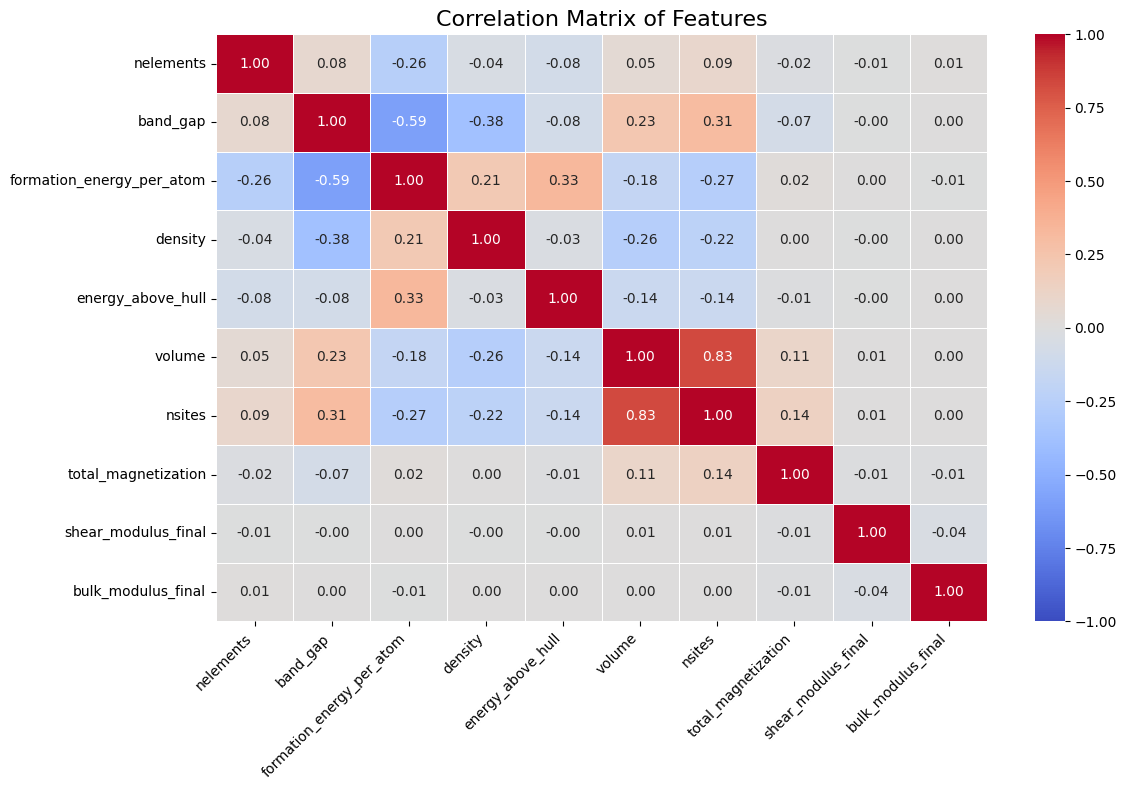

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, features=None):
    """Plot correlation matrix for the given features."""
    # If specific features are provided, filter the DataFrame
    if features:
        df = df[features]

    # Exclude non-numeric columns
    df_numeric = df.select_dtypes(include='number')

    # Calculate the correlation matrix
    corr_matrix = df_numeric.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Generate a heatmap of the correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

    # Set title and labels
    plt.title('Correlation Matrix of Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Usage example
# Plot correlation matrix for all features in the cleaned DataFrame
plot_correlation_matrix(df_cleaned)

In [11]:
from mp_api.client import MPRester

def add_lattice_constants(df):
    a_vals, b_vals, c_vals = [], [], []
    alpha_vals, beta_vals, gamma_vals = [], [], []

    with MPRester(APIKEY) as mpr:
        for mpid in df['material_id']:
            try:
                struct = mpr.get_structure_by_material_id(mpid)
                a, b, c = struct.lattice.abc
                alpha, beta, gamma = struct.lattice.angles
                a_vals.append(a)
                b_vals.append(b)
                c_vals.append(c)
                alpha_vals.append(alpha)
                beta_vals.append(beta)
                gamma_vals.append(gamma)
            except Exception as e:
                print(f"Error retrieving lattice data for {mpid}: {e}")
                a_vals.append(None)
                b_vals.append(None)
                c_vals.append(None)
                alpha_vals.append(None)
                beta_vals.append(None)
                gamma_vals.append(None)

    df['lattice_a'] = a_vals
    df['lattice_b'] = b_vals
    df['lattice_c'] = c_vals
    df['lattice_alpha'] = alpha_vals
    df['lattice_beta'] = beta_vals
    df['lattice_gamma'] = gamma_vals

    return df

df_with_lattice = add_lattice_constants(df_cleaned)


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 22192.08it/s]


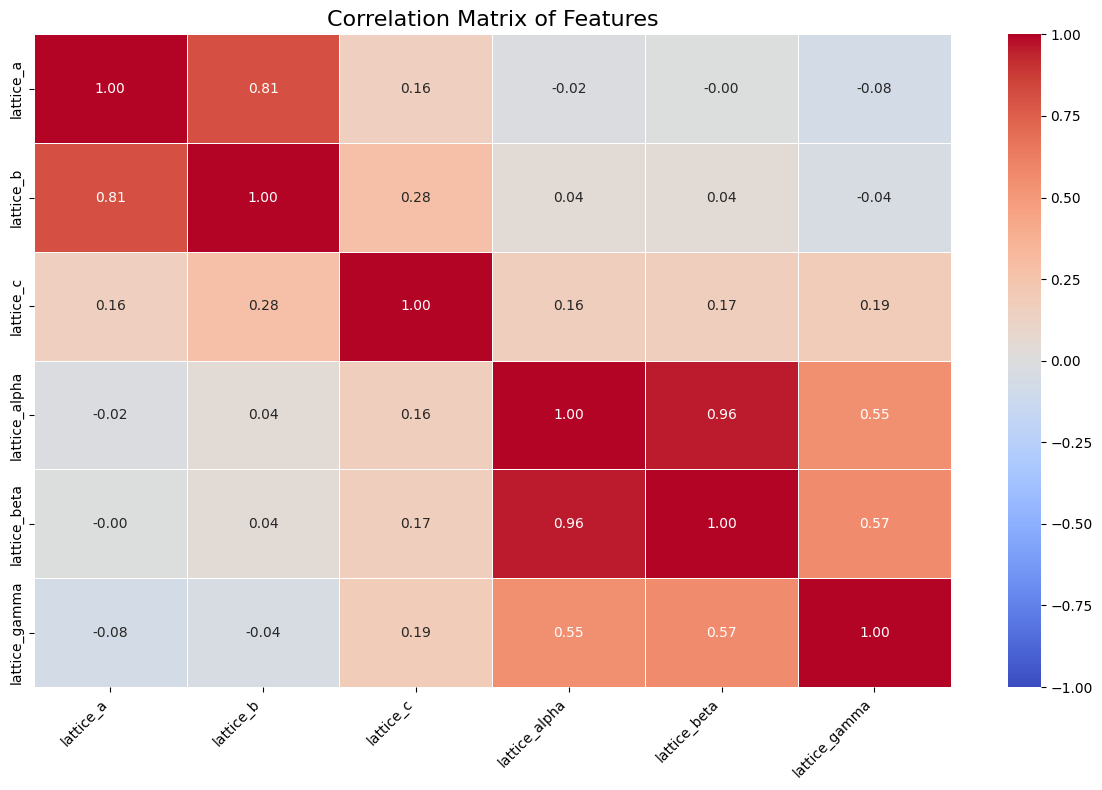

In [12]:
plot_correlation_matrix(df_with_lattice, features=["lattice_a", "lattice_b", "lattice_c", "lattice_alpha", "lattice_beta", "lattice_gamma"])

In [42]:
# Train/Test Split

def train_test_split_custom(df):
    from sklearn.model_selection import train_test_split
    
    # Define target columns and feature columns
    target_columns = ["lattice_a", "lattice_b", "lattice_c", "lattice_alpha", "lattice_beta", "lattice_gamma"]
    X = df.drop(columns=target_columns + ['material_id'] + ['formula'] + ['elements'])
    Y = df[target_columns]

    # Split the dataset into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # More aggressive outlier removal using a higher IQR factor
    def remove_outliers(X, factor=3.0):
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return X[(X >= lower_bound) & (X <= upper_bound)].dropna()

    # Apply outlier removal on both training and testing feature sets
    X_train_no_outliers = X_train.apply(lambda col: remove_outliers(col, factor=3.0))
    X_test_no_outliers = X_test.apply(lambda col: remove_outliers(col, factor=3.0))

    # Drop any rows with NaN values after removing outliers
    X_train_no_outliers = X_train_no_outliers.dropna()
    Y_train_aligned = Y_train.loc[X_train_no_outliers.index]  # Align Y_train with X_train_no_outliers
    X_test_no_outliers = X_test_no_outliers.dropna()
    Y_test_aligned = Y_test.loc[X_test_no_outliers.index]    # Align Y_test with X_test_no_outliers

    return X_train_no_outliers, X_test_no_outliers, Y_train_aligned, Y_test_aligned


In [43]:
# Scaling and transforming the features
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def scale_and_transform(X_train, X_test, Y_train, Y_test):
  # Preserve the indices before scaling
  X_train_indices = X_train.index
  X_test_indices = X_test.index

  # Scaling the features (X)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)  # fit only on training data
  X_test_scaled = scaler.transform(X_test)        # apply same transform to test data

  # Apply log transformation to selected columns with extreme values
  columns_to_log = ['shear_modulus_final', 'bulk_modulus_final', 'volume']
  X_train[columns_to_log] = X_train[columns_to_log].apply(np.log1p)  # log1p handles zeros better
  X_test[columns_to_log] = X_test[columns_to_log].apply(np.log1p)

  # Re-standardize after log transformation
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Convert numpy arrays back to DataFrames, preserving the indices
  X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train_indices)
  X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test_indices)

  # Handle missing values by dropping rows with NaNs if necessary
  X_train_scaled = X_train_scaled.dropna()
  Y_train_aligned = Y_train.loc[X_train_scaled.index]  # Align Y_train with X_train_scaled
  X_test_scaled = X_test_scaled.dropna()
  Y_test_aligned = Y_test.loc[X_test_scaled.index]    # Align Y_test with X_test_scaled

  return X_train_scaled, X_test_scaled, Y_train_aligned, Y_test_aligned


In [44]:
# functions for evaluating and plotting multi-output regression results

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_multioutput_regression(y_true, y_pred, target_names=None):
    n_targets = y_true.shape[1]
    print("Performance Metrics per Output:\n")
    
    for i in range(n_targets):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        
        name = target_names[i] if target_names else f"Target {i+1}"
        print(f"{name}:")
        print(f"  R²   = {r2:.3f}")
        print(f"  MAE  = {mae:.3f}")
        print(f"  MSE  = {mse:.3f}\n")


def plot_multioutput_regression_results(y_true, y_pred, target_names=None):
    n_targets = y_true.shape[1]
    
    # Adjust the figure size and layout based on the number of targets
    fig, axs = plt.subplots(2, int(np.ceil(n_targets / 2)), figsize=(20, 12))
    axs = axs.flatten()

    for i in range(n_targets):
        # Calculate R² for the current target
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        # Plot the scatter plot
        sns.scatterplot(x=y_true[:, i], y=y_pred[:, i], alpha=0.5, ax=axs[i])
        
        # Plot the identity line (true values = predicted values)
        axs[i].plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()],
                    'r--', lw=2)
        
        # Set labels and title
        name = target_names[i] if target_names else f"Target {i+1}"
        axs[i].set_title(f"{name} (R² = {r2:.3f})")
        axs[i].set_xlabel("True Values")
        axs[i].set_ylabel("Predicted Values")
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.suptitle("Predicted vs True Values for Lattice Parameters", fontsize=16, y=1.02)
    plt.show()


Linear Regression Model Performance:
R² = 0.285
MSE = 191.391
Performance Metrics per Output:

lattice_a:
  R²   = 0.316
  MAE  = 0.666
  MSE  = 0.971

lattice_b:
  R²   = 0.503
  MAE  = 0.576
  MSE  = 0.783

lattice_c:
  R²   = 0.399
  MAE  = 1.046
  MSE  = 3.532

lattice_alpha:
  R²   = 0.155
  MAE  = 14.098
  MSE  = 335.617

lattice_beta:
  R²   = 0.146
  MAE  = 14.009
  MSE  = 327.238

lattice_gamma:
  R²   = 0.192
  MAE  = 17.553
  MSE  = 480.206



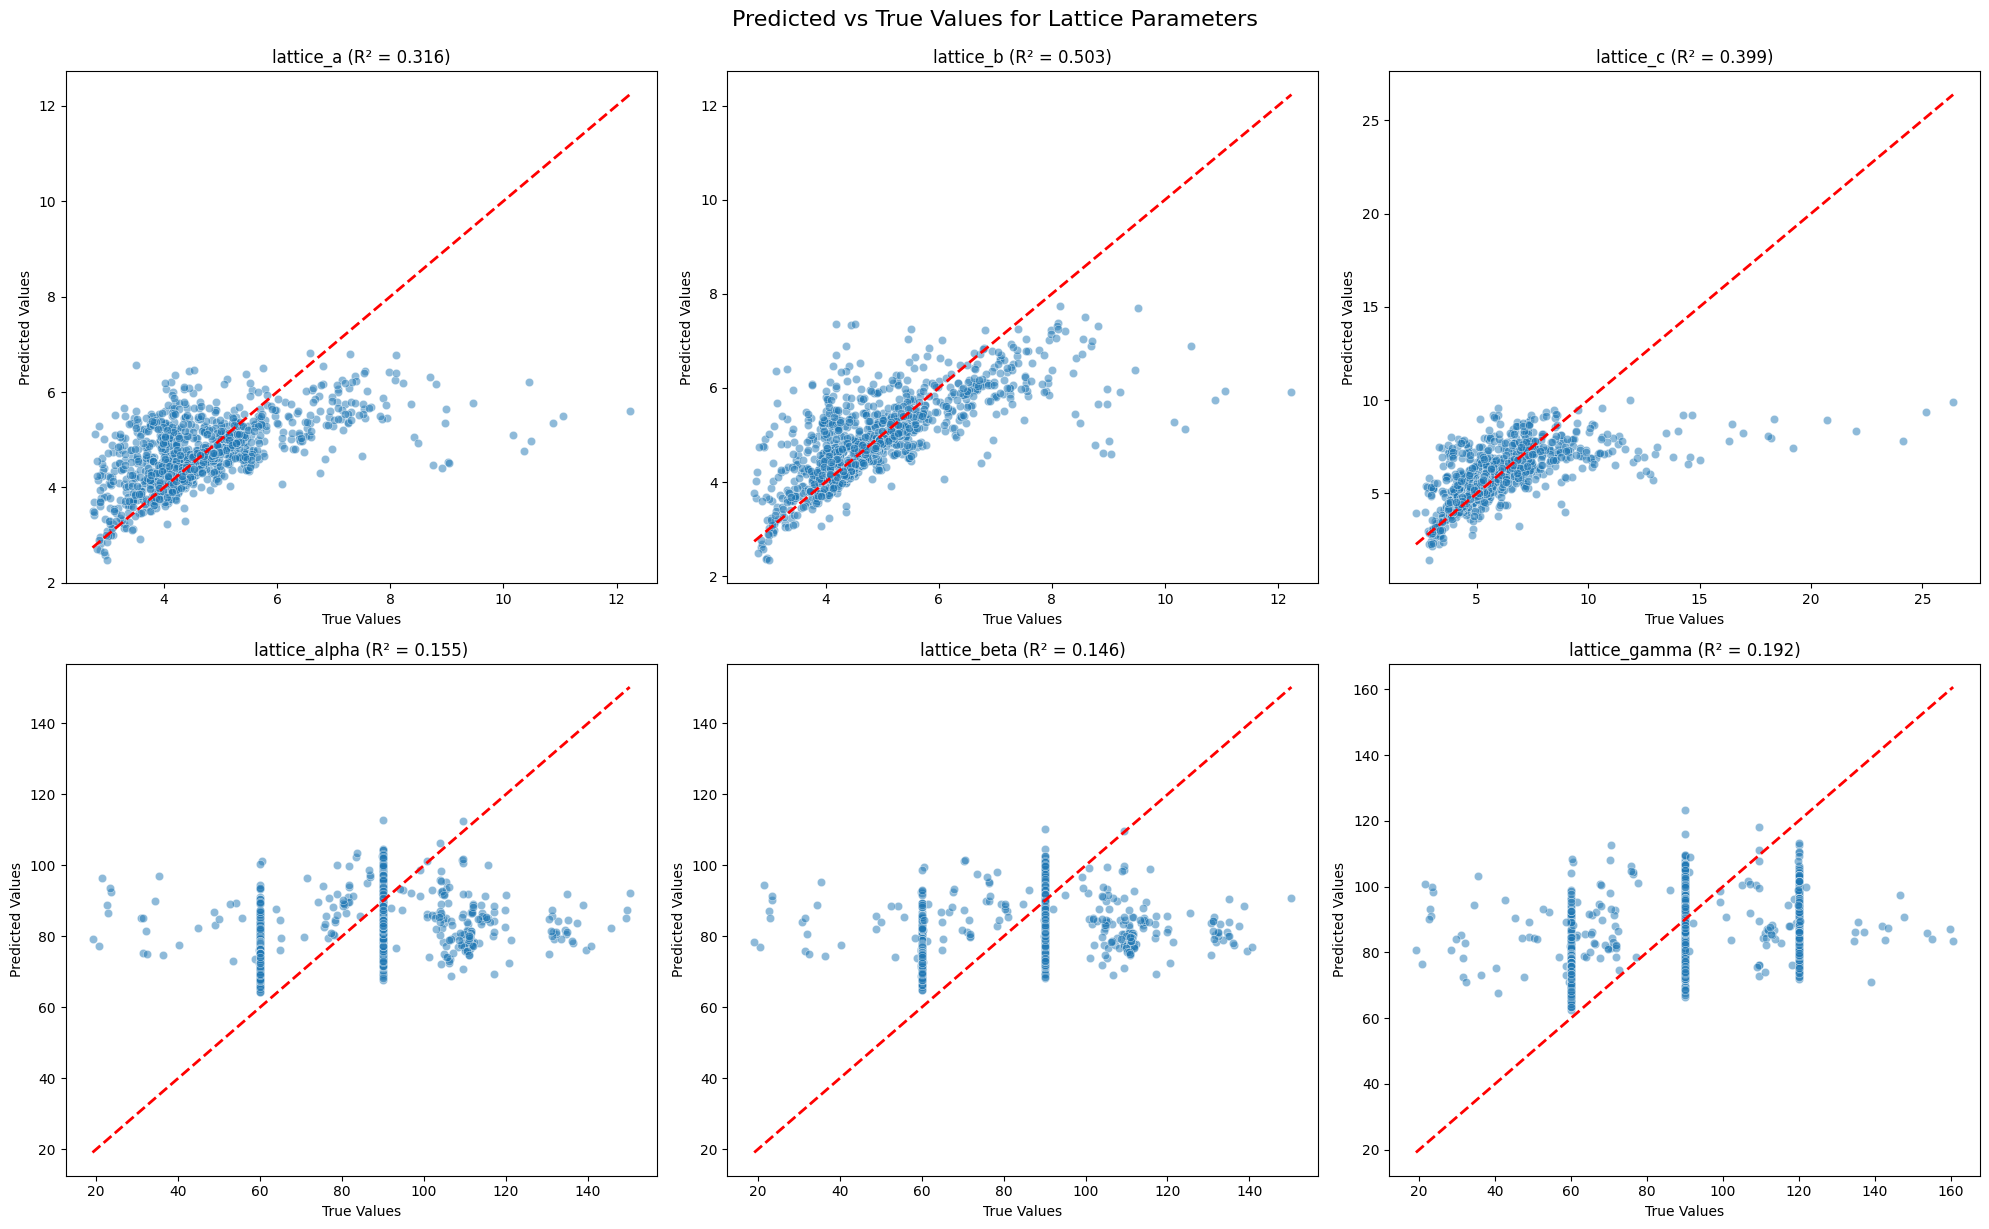

In [45]:
# Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train_linreg, X_testlinreg, Y_trainlinreg, Y_testlinreg = train_test_split_custom(df_with_lattice)
X_train_scaled_linreg, X_test_scaled_linreg, Y_train_aligned_linreg, Y_test_aligned_linreg = scale_and_transform(X_train_linreg, X_testlinreg, Y_trainlinreg, Y_testlinreg)

model = LinearRegression()
model.fit(X_train_scaled_linreg, Y_train_aligned_linreg)

# Predict
y_pred_linreg = model.predict(X_test_scaled_linreg)
lattice_features = [
    "lattice_a", "lattice_b", "lattice_c",
    "lattice_alpha", "lattice_beta", "lattice_gamma"
]
r2 = r2_score(Y_test_aligned_linreg, y_pred_linreg)
mse = mean_squared_error(Y_test_aligned_linreg, y_pred_linreg)
print(f"\nLinear Regression Model Performance:")
print(f"R² = {r2:.3f}")
print(f"MSE = {mse:.3f}")

# Evaluate
evaluate_multioutput_regression(Y_test_aligned_linreg.to_numpy(), y_pred_linreg, target_names=lattice_features)

# Plot
plot_multioutput_regression_results(Y_test_aligned_linreg.to_numpy(), y_pred_linreg, target_names=lattice_features)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'estimator__alpha': 1.0, 'estimator__l1_ratio': 0.1}

Optimized ElasticNet Model Performance:
R² = 0.219
MSE = 201.742
Performance Metrics per Output:

lattice_a:
  R²   = 0.230
  MAE  = 0.738
  MSE  = 1.093

lattice_b:
  R²   = 0.403
  MAE  = 0.677
  MSE  = 0.941

lattice_c:
  R²   = 0.320
  MAE  = 1.196
  MSE  = 4.000

lattice_alpha:
  R²   = 0.116
  MAE  = 14.922
  MSE  = 351.339

lattice_beta:
  R²   = 0.107
  MAE  = 14.955
  MSE  = 342.151

lattice_gamma:
  R²   = 0.141
  MAE  = 18.645
  MSE  = 510.929



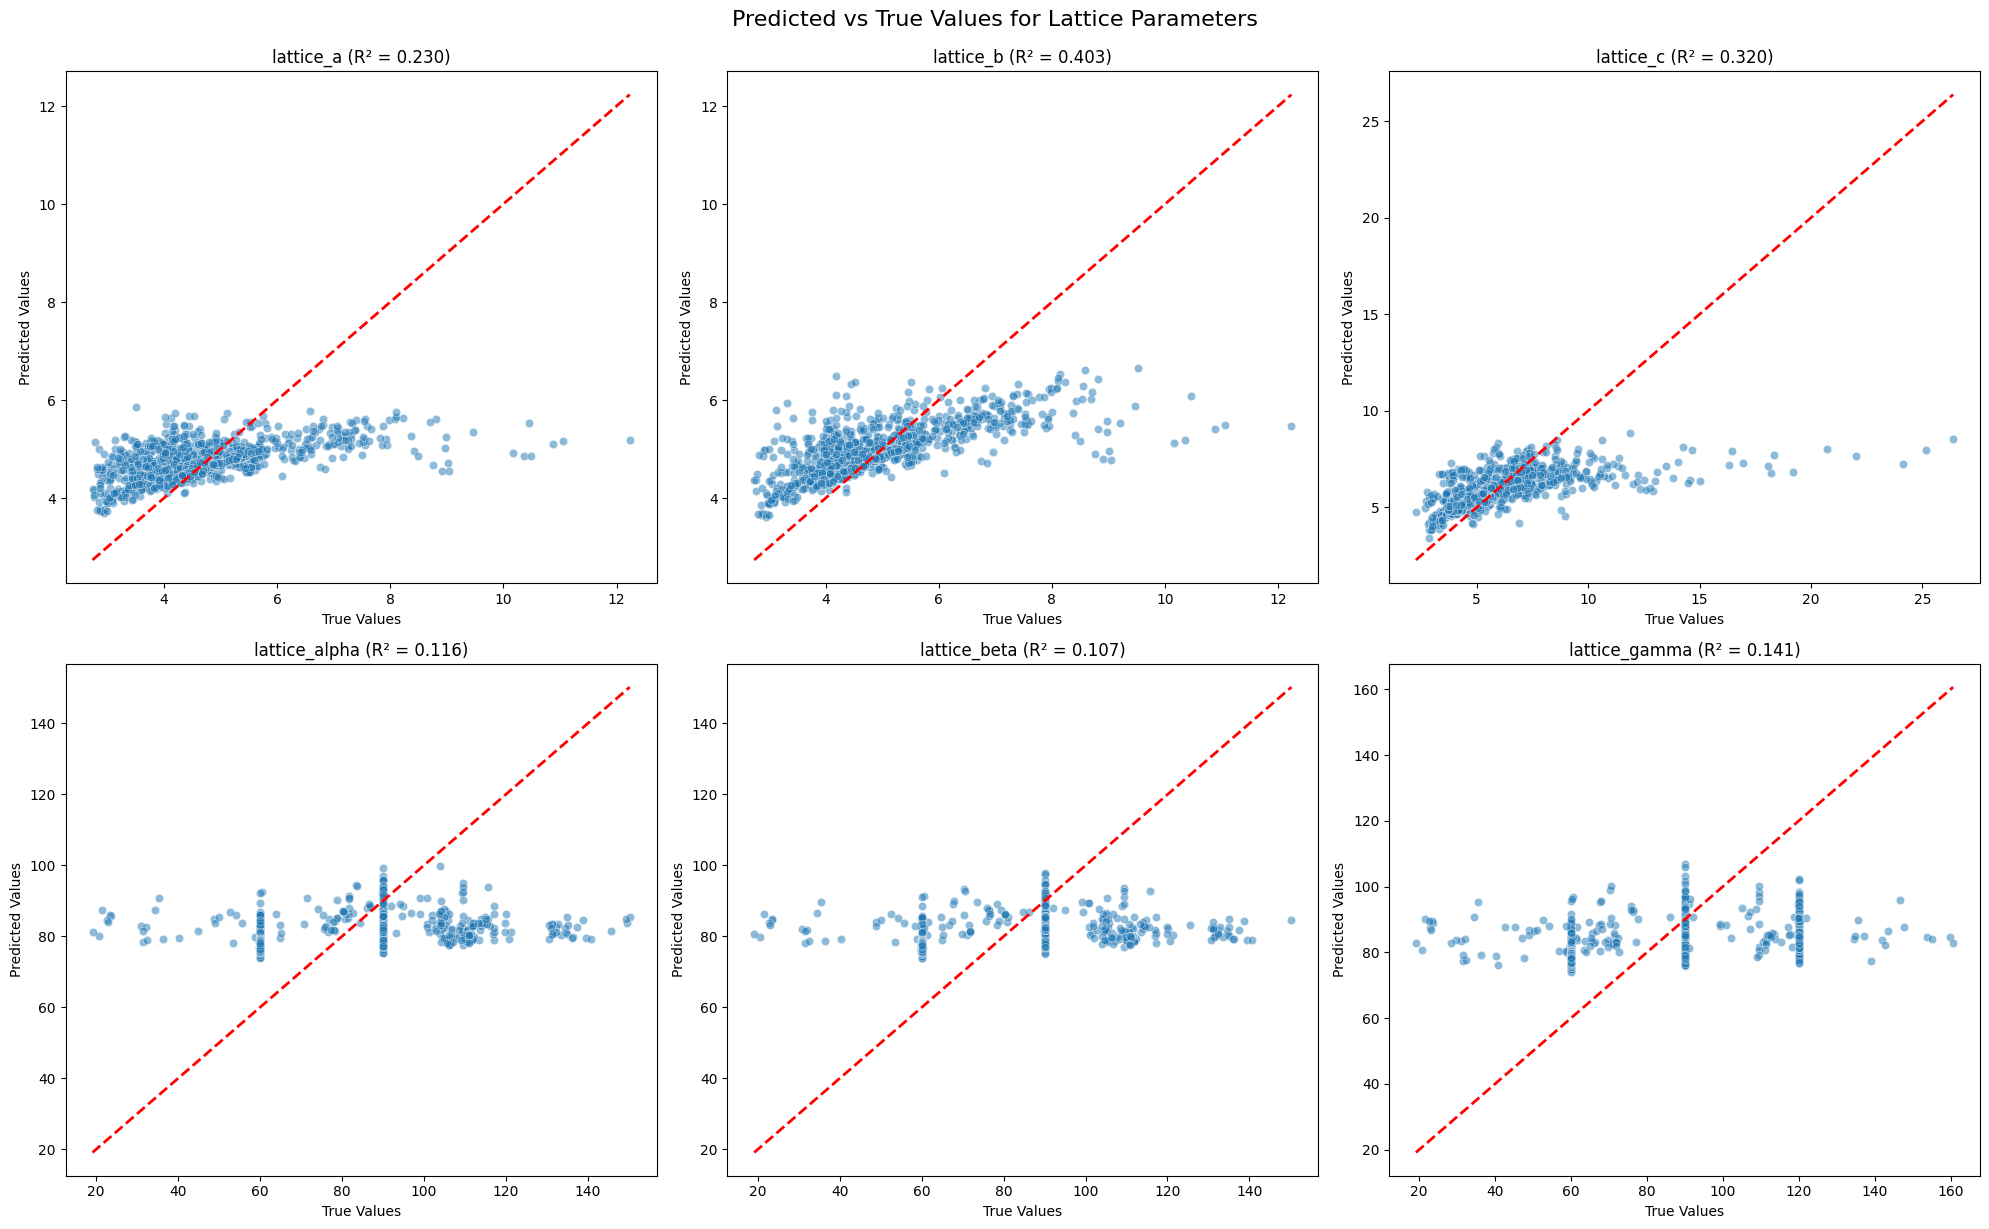

In [47]:
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Train/test split and scaling
X_train_EN, X_test_EN, Y_train_EN, Y_test_EN = train_test_split_custom(df_with_lattice)
X_train_scaled_EN, X_test_scaled_EN, Y_train_aligned_EN, Y_test_aligned_EN = scale_and_transform(
    X_train_EN, X_test_EN, Y_train_EN, Y_test_EN
)

# Define base ElasticNet estimator
base_elastic_net = ElasticNet(max_iter=10000)

# Wrap in MultiOutputRegressor
multi_elastic_net = MultiOutputRegressor(base_elastic_net)

# Grid search parameters
param_grid = {
    'estimator__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'estimator__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
}

# GridSearchCV
grid_search = GridSearchCV(multi_elastic_net, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled_EN, Y_train_aligned_EN)

print("Best parameters found:", grid_search.best_params_)

# Predict with the best model
best_model = grid_search.best_estimator_
Y_pred_EN = best_model.predict(X_test_scaled_EN)

# Overall evaluation
r2 = r2_score(Y_test_aligned_EN, Y_pred_EN)
mse = mean_squared_error(Y_test_aligned_EN, Y_pred_EN)

print(f"\nOptimized ElasticNet Model Performance:")
print(f"R² = {r2:.3f}")
print(f"MSE = {mse:.3f}")

# Evaluate and Plot
evaluate_multioutput_regression(Y_test_aligned_EN.to_numpy(), Y_pred_EN, target_names=lattice_features)
plot_multioutput_regression_results(Y_test_aligned_EN.to_numpy(), Y_pred_EN, target_names=lattice_features)


Training model for: lattice_a
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Best Params = {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
  Mean R²     = 0.451

Training model for: lattice_b
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Best Params = {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
  Mean R²     = 0.573

Training model for: lattice_c
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Best Params = {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
  Mean R²     = 0.559

Training model for: lattice_alpha
Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Best Params = {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'max_dep

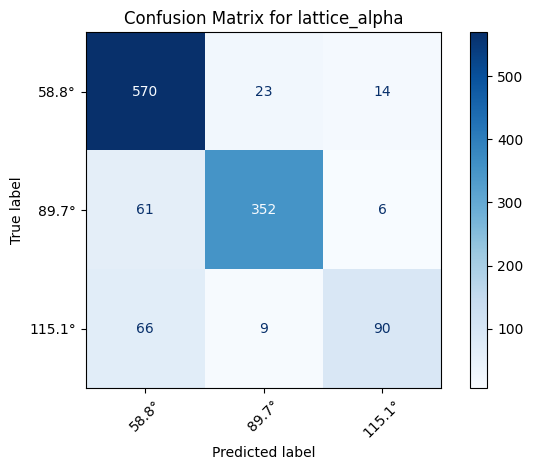


Classification Report for lattice_alpha:

              precision    recall  f1-score   support

       58.8°       0.82      0.94      0.87       607
       89.7°       0.92      0.84      0.88       419
      115.1°       0.82      0.55      0.65       165

    accuracy                           0.85      1191
   macro avg       0.85      0.77      0.80      1191
weighted avg       0.85      0.85      0.84      1191



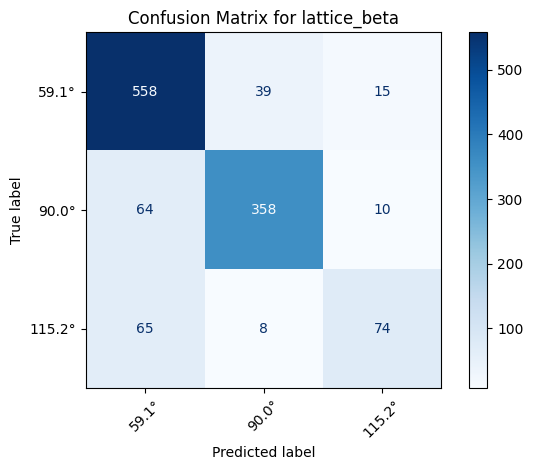


Classification Report for lattice_beta:

              precision    recall  f1-score   support

       59.1°       0.81      0.91      0.86       612
       90.0°       0.88      0.83      0.86       432
      115.2°       0.75      0.50      0.60       147

    accuracy                           0.83      1191
   macro avg       0.81      0.75      0.77      1191
weighted avg       0.83      0.83      0.83      1191



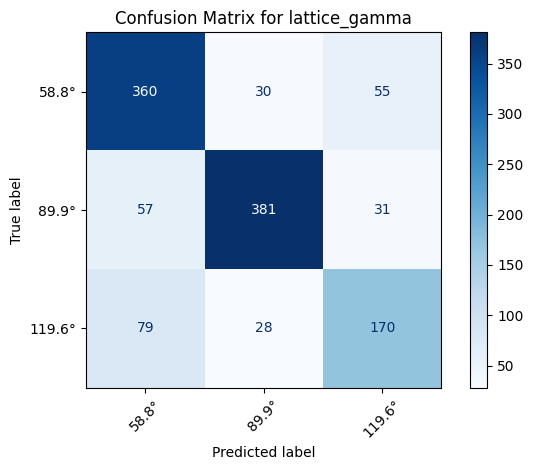


Classification Report for lattice_gamma:

              precision    recall  f1-score   support

       58.8°       0.73      0.81      0.77       445
       89.9°       0.87      0.81      0.84       469
      119.6°       0.66      0.61      0.64       277

    accuracy                           0.76      1191
   macro avg       0.75      0.75      0.75      1191
weighted avg       0.77      0.76      0.76      1191



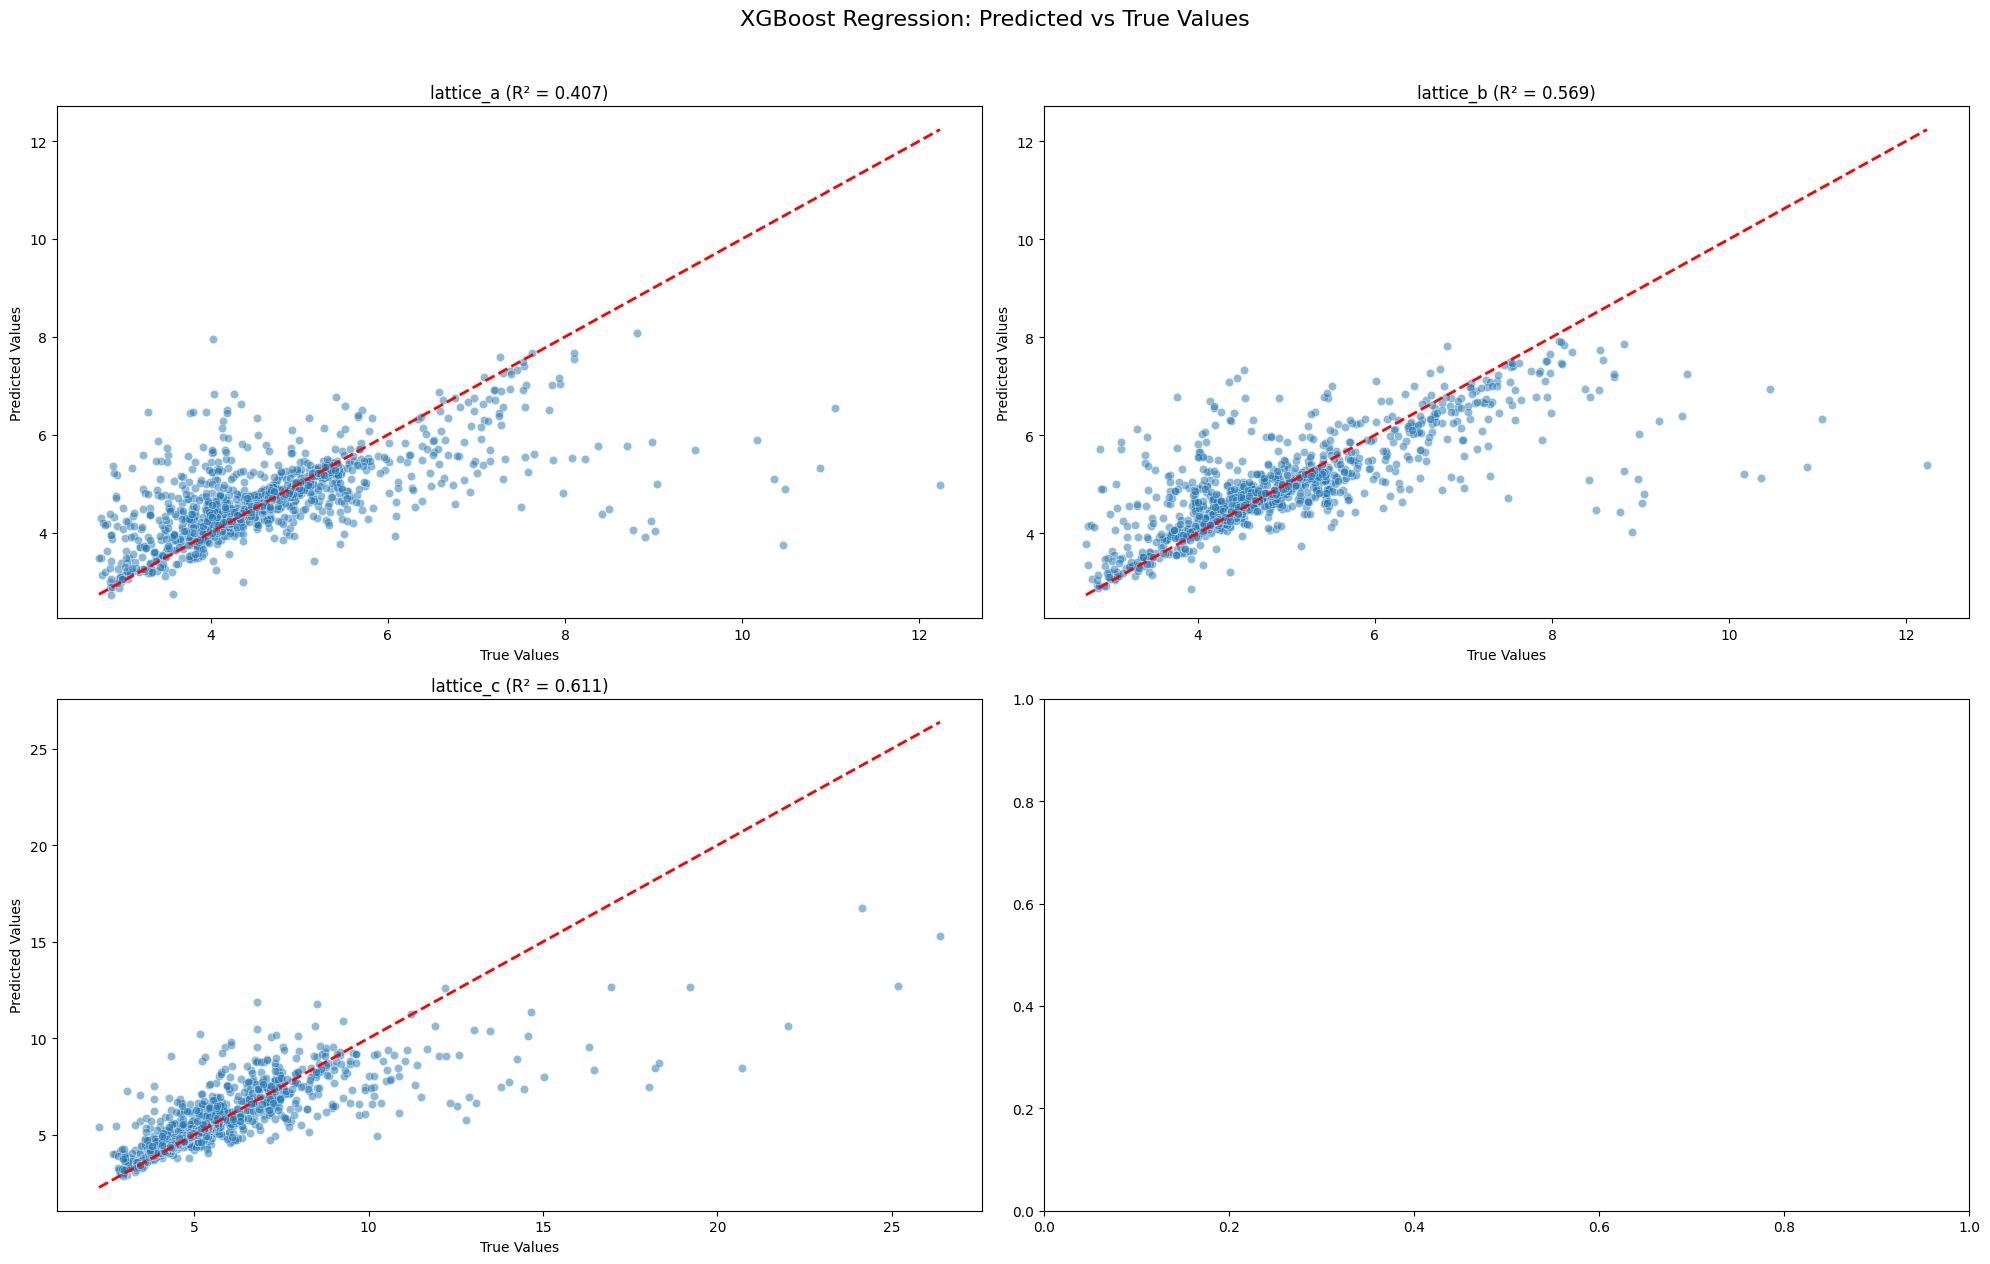

In [58]:
# XGBoost Regression with GridSearchCV, Early Stopping, and Regularization

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, f1_score
from sklearn.cluster import KMeans
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom train-test split and scaling
X_train_XG, X_test_XG, Y_train_XG, Y_test_XG = train_test_split_custom(df_with_lattice)
X_train_scaled_XG, X_test_scaled_XG, Y_train_aligned_XG, Y_test_aligned_XG = scale_and_transform(
    X_train_XG, X_test_XG, Y_train_XG, Y_test_XG
)

# Target columns
target_columns = ['lattice_a', 'lattice_b', 'lattice_c', 'lattice_alpha', 'lattice_beta', 'lattice_gamma']

# Parameter grid including regularization
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10],
}

# KFold CV for consistency
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to hold models and metrics
xgb_models = {}
performance_metrics = {}
kmeans_models = {}
bin_centers_dict = {}

# Angular targets to classify
angle_targets = ['lattice_alpha', 'lattice_beta', 'lattice_gamma']

# Train a separate model for each target
for target in target_columns:
    print(f"\nTraining model for: {target}")
    
    y_train_target = Y_train_aligned_XG[target]
    y_test_target = Y_test_aligned_XG[target]
    
    # Check if target is an angular value
    is_angle = target in angle_targets

    if is_angle:
        # Classification setup with binning
        num_bins = 3
        kmeans = KMeans(n_clusters=num_bins, random_state=42)
        labels = kmeans.fit_predict(y_train_target.values.reshape(-1, 1))
        y_train_binned = labels
        bin_centers = np.sort(kmeans.cluster_centers_.flatten())

        base_model = xgb.XGBClassifier(
            n_jobs=-1,
            verbosity=0,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
    else:
        # Standard regression
        base_model = xgb.XGBRegressor(
            n_jobs=-1,
            verbosity=0,
            objective='reg:squarederror'
        )

    if is_angle:
    # Grid search setup
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grid,
            n_iter=50,
            scoring='f1_macro',  # Use macro F1-score for classification
            cv=cv,
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
    else:
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grid,
            n_iter=50,
            scoring='r2',  # Use R² for regression
            cv=cv,
            n_jobs=-1,
            verbose=1,
            random_state=42
        )

    # Early stopping split
    split_index = int(len(X_train_scaled_XG) * 0.9)
    X_train_early = X_train_scaled_XG[:split_index]
    X_val_early = X_train_scaled_XG[split_index:]

    if is_angle:
        y_train_early = y_train_binned[:split_index]
        # Apply the trained KMeans model to validation values
        y_val_raw = y_train_target[split_index:].values.reshape(-1, 1)
        y_val_early = kmeans.predict(y_val_raw)
    else:
        y_train_early = y_train_target[:split_index]
        y_val_early = y_train_target[split_index:]

    # Fit the model
    if is_angle:
        random_search.fit(X_train_scaled_XG, y_train_binned, eval_set=[(X_val_early, y_val_early)], verbose=False)
    else:
        random_search.fit(X_train_scaled_XG, y_train_target, eval_set=[(X_val_early, y_val_early)], verbose=False)

    best_model = random_search.best_estimator_
    xgb_models[target] = best_model

    if is_angle:
        # Use validation F1-score for classification with bin centers
        y_val_pred_class = best_model.predict(X_val_early)
        y_val_true_class = y_val_early  # Already predicted KMeans labels

        # Compute macro F1-score
        f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

        # Store KMeans model and bin centers
        kmeans_models[target] = kmeans
        bin_centers_dict[target] = bin_centers

    else:
        r2 = random_search.best_score_

    if is_angle:
        performance_metrics[target] = {
            'Mean F1': f1,
            'Std F1': random_search.cv_results_['std_test_score'][random_search.best_index_]
        }
        print(f"  Best Params = {random_search.best_params_}")
        print(f"  Mean F1    = {f1:.3f}")
    else:
        performance_metrics[target] = {
            'Mean R2': r2,
            'Std R2': random_search.cv_results_['std_test_score'][random_search.best_index_]
        }
        print(f"  Best Params = {random_search.best_params_}")
        print(f"  Mean R²     = {r2:.3f}")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Your angle targets
angle_targets = ['lattice_alpha', 'lattice_beta', 'lattice_gamma']

for i, target in enumerate(target_columns):
    model = xgb_models[target]
    y_test = Y_test_aligned_XG[target]
    
    if target in angle_targets:
        # CLASSIFICATION
        # Recreate binning via KMeans for the test set
        kmeans = kmeans_models[target]  # This assumes you're storing one per angle target
        y_true = kmeans.predict(y_test.values.reshape(-1, 1))         # True bin labels
        y_pred = model.predict(X_test_scaled_XG).astype(int)          # Predicted bin labels

        bin_centers = bin_centers_dict[target]  # Get bin centers

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=range(len(bin_centers)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{b:.1f}°" for b in bin_centers])
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Confusion Matrix for {target}")
        plt.tight_layout()
        plt.show()

        # Classification Report
        print(f"\nClassification Report for {target}:\n")
        print(classification_report(y_true, y_pred, target_names=[f"{b:.1f}°" for b in bin_centers]))

# Collect regression targets only
regression_targets = [t for t in target_columns if t not in ['lattice_alpha', 'lattice_beta', 'lattice_gamma']]
n_regression = len(regression_targets)

# Prepare the subplots
fig, axs = plt.subplots(2, int(np.ceil(n_regression / 2)), figsize=(20, 12))
axs = axs.flatten()

for i, target in enumerate(regression_targets):
    model = xgb_models[target]
    y_test = Y_test_aligned_XG[target]
    y_pred = model.predict(X_test_scaled_XG)

    r2 = r2_score(y_test, y_pred)

    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=axs[i])
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axs[i].set_xlabel("True Values")
    axs[i].set_ylabel("Predicted Values")
    axs[i].set_title(f"{target} (R² = {r2:.3f})")

# Clean up layout
plt.tight_layout()
plt.suptitle("XGBoost Regression: Predicted vs True Values", fontsize=16, y=1.05)
plt.show()


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/mylesgrant/CrystalClassification/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.158e+03, tolerance: 2.979e+02
  model = cd_fast.enet_coordinate_descent(
/Users/mylesgrant/CrystalClassification/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.244e+03, tolerance: 2.873e+02
  model = cd_fast.enet_coordinate_descent(
/Users/mylesgrant/CrystalClassification/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best parameters found: {'poly__degree': 2, 'regressor__estimator__alpha': 0.1, 'regressor__estimator__l1_ratio': 0.1}

Optimized Polynomial Regression Model Performance:
R² = 0.316
MSE = 200.672
Performance Metrics per Output:

lattice_a:
  R²   = 0.459
  MAE  = 0.768
  MSE  = 1.212

lattice_b:
  R²   = 0.628
  MAE  = 0.651
  MSE  = 0.944

lattice_c:
  R²   = 0.381
  MAE  = 1.288
  MSE  = 5.659

lattice_alpha:
  R²   = 0.123
  MAE  = 13.763
  MSE  = 375.409

lattice_beta:
  R²   = 0.124
  MAE  = 13.277
  MSE  = 353.660

lattice_gamma:
  R²   = 0.180
  MAE  = 17.023
  MSE  = 467.149



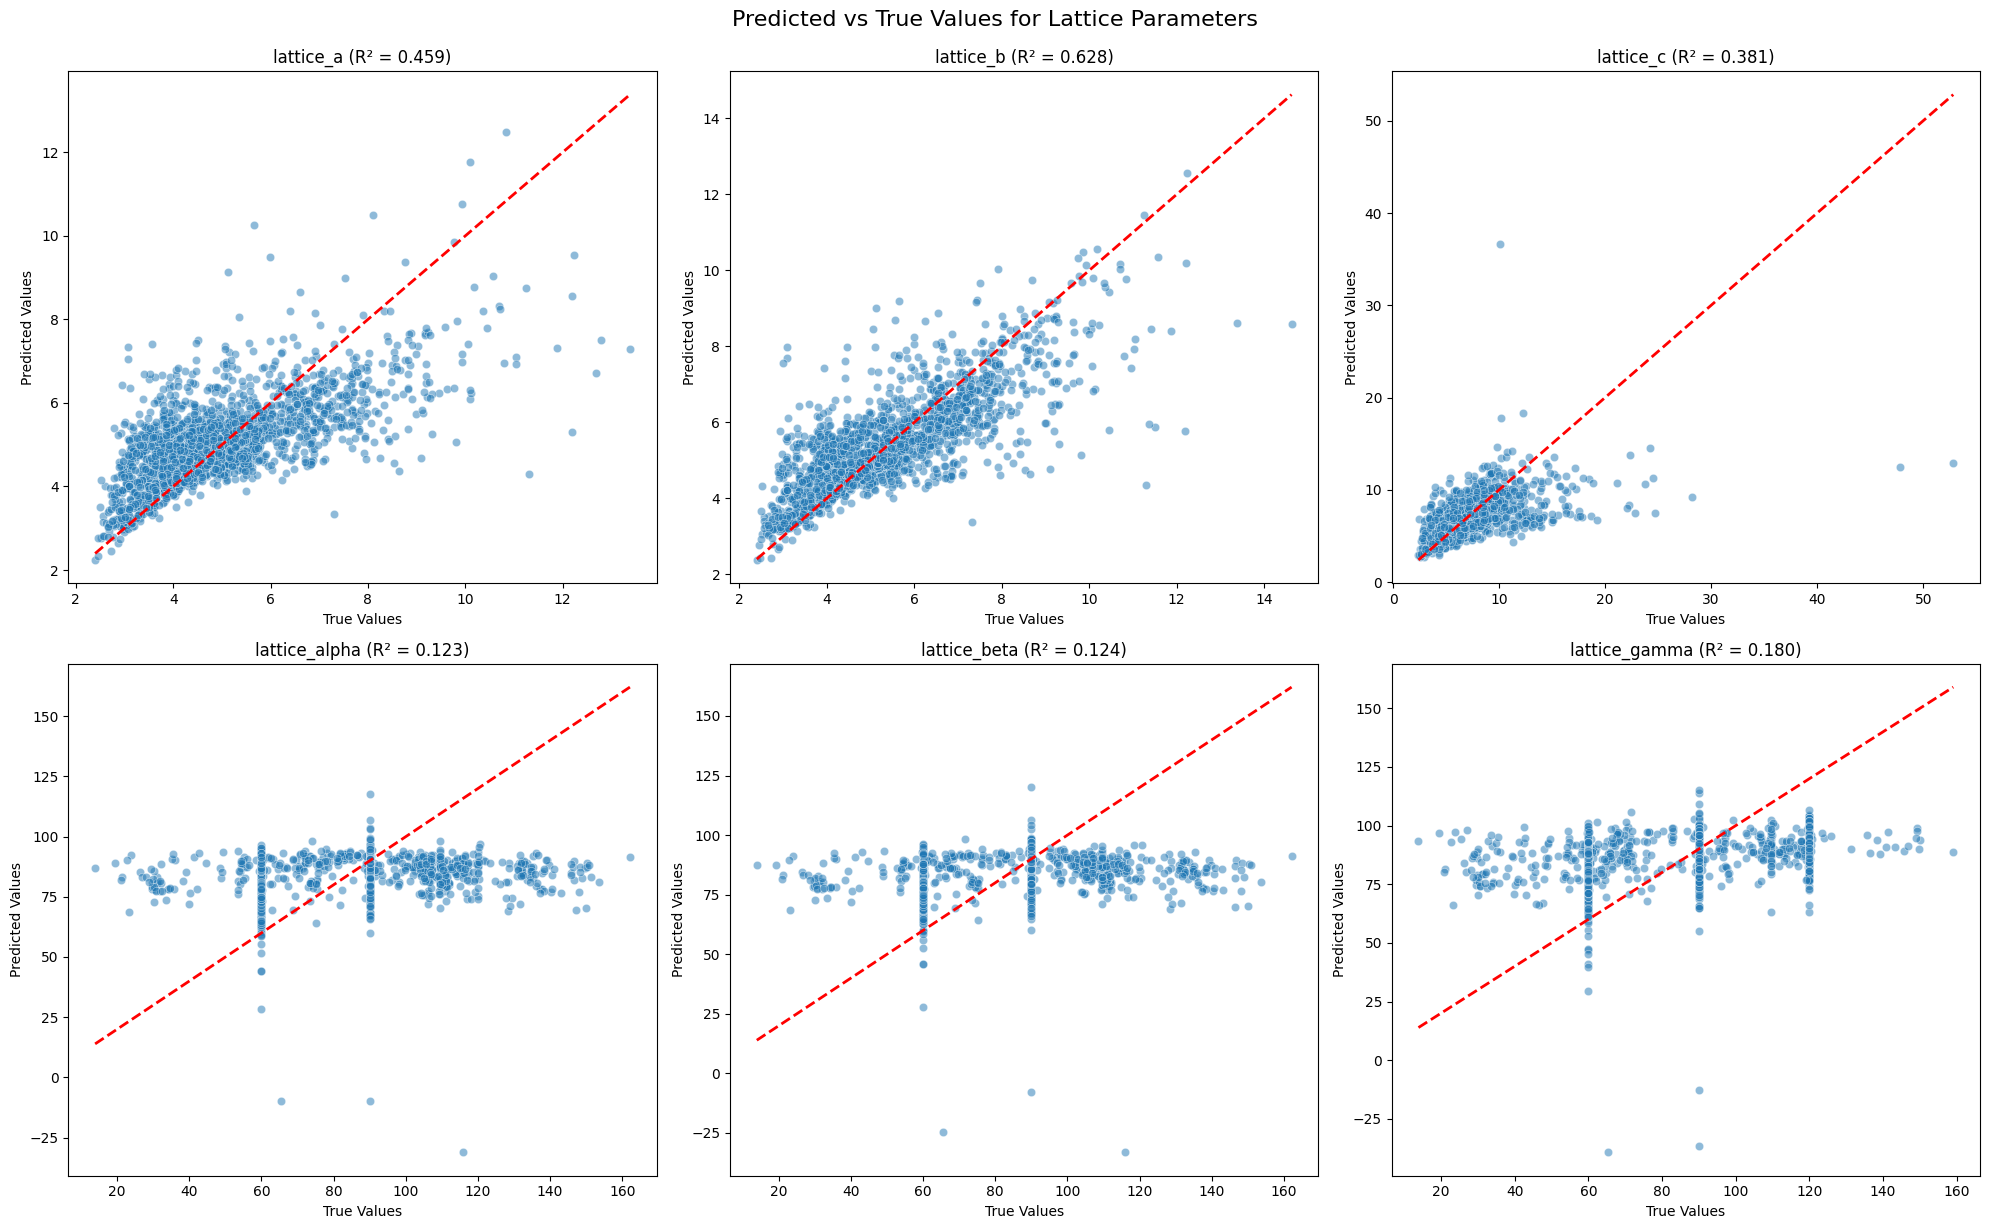

In [ ]:
# Polynomial Regression with MultiOutputRegressor and GridSearchCV
# This one takes an hour and a half to run (don't run unless you have to)
# Didn't even end up being the best model, but it's good to have in the notebook

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Train/test split and scaling
X_train_Poly, X_test_Poly, Y_train_Poly, Y_test_Poly = train_test_split_custom(df_with_lattice)
X_train_scaled_Poly, X_test_scaled_Poly, Y_train_aligned_Poly, Y_test_aligned_Poly = scale_and_transform(
    X_train_Poly, X_test_Poly, Y_train_Poly, Y_test_Poly
)

# Define the base ElasticNet estimator
base_elastic_net = ElasticNet(max_iter=10000)

# Polynomial feature transformation
poly = PolynomialFeatures(degree=2)  # Change degree for higher polynomials

# Create the pipeline with PolynomialFeatures and MultiOutputRegressor
multi_poly_elastic_net = Pipeline([
    ('poly', poly),
    ('regressor', MultiOutputRegressor(base_elastic_net))  # Apply ElasticNet to each target
])

# Grid search parameters for both polynomial features and ElasticNet hyperparameters
param_grid = {
    'poly__degree': [2, 3, 4],  # Experiment with polynomial degrees
    'regressor__estimator__alpha': [0.1, 1.0, 10.0],
    'regressor__estimator__l1_ratio': [0.1, 0.5, 0.9],
}

# GridSearchCV to optimize both polynomial degree and ElasticNet parameters
grid_search = GridSearchCV(multi_poly_elastic_net, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled_Poly, Y_train_aligned_Poly)

# Print the best parameters found by GridSearchCV
print("Best parameters found:", grid_search.best_params_)

# Predict with the best model
best_model = grid_search.best_estimator_
Y_pred_Poly = best_model.predict(X_test_scaled_Poly)

# Overall evaluation
r2 = r2_score(Y_test_aligned_Poly, Y_pred_Poly)
mse = mean_squared_error(Y_test_aligned_Poly, Y_pred_Poly)

print(f"\nOptimized Polynomial Regression Model Performance:")
print(f"R² = {r2:.3f}")
print(f"MSE = {mse:.3f}")

# Evaluate and Plot
evaluate_multioutput_regression(Y_test_aligned_Poly.to_numpy(), Y_pred_Poly, target_names=lattice_features)
plot_multioutput_regression_results(Y_test_aligned_Poly.to_numpy(), Y_pred_Poly, target_names=lattice_features)



Optimized Polynomial Regression Model Performance:
R² = 0.324
MSE = 203.382
Performance Metrics per Output:

lattice_a:
  R²   = 0.459
  MAE  = 0.768
  MSE  = 1.212

lattice_b:
  R²   = 0.628
  MAE  = 0.651
  MSE  = 0.944

lattice_c:
  R²   = 0.381
  MAE  = 1.288
  MSE  = 5.659

lattice_alpha:
  R²   = 0.123
  MAE  = 13.763
  MSE  = 375.409

lattice_beta:
  R²   = 0.124
  MAE  = 13.277
  MSE  = 353.660

lattice_gamma:
  R²   = 0.180
  MAE  = 17.023
  MSE  = 467.149



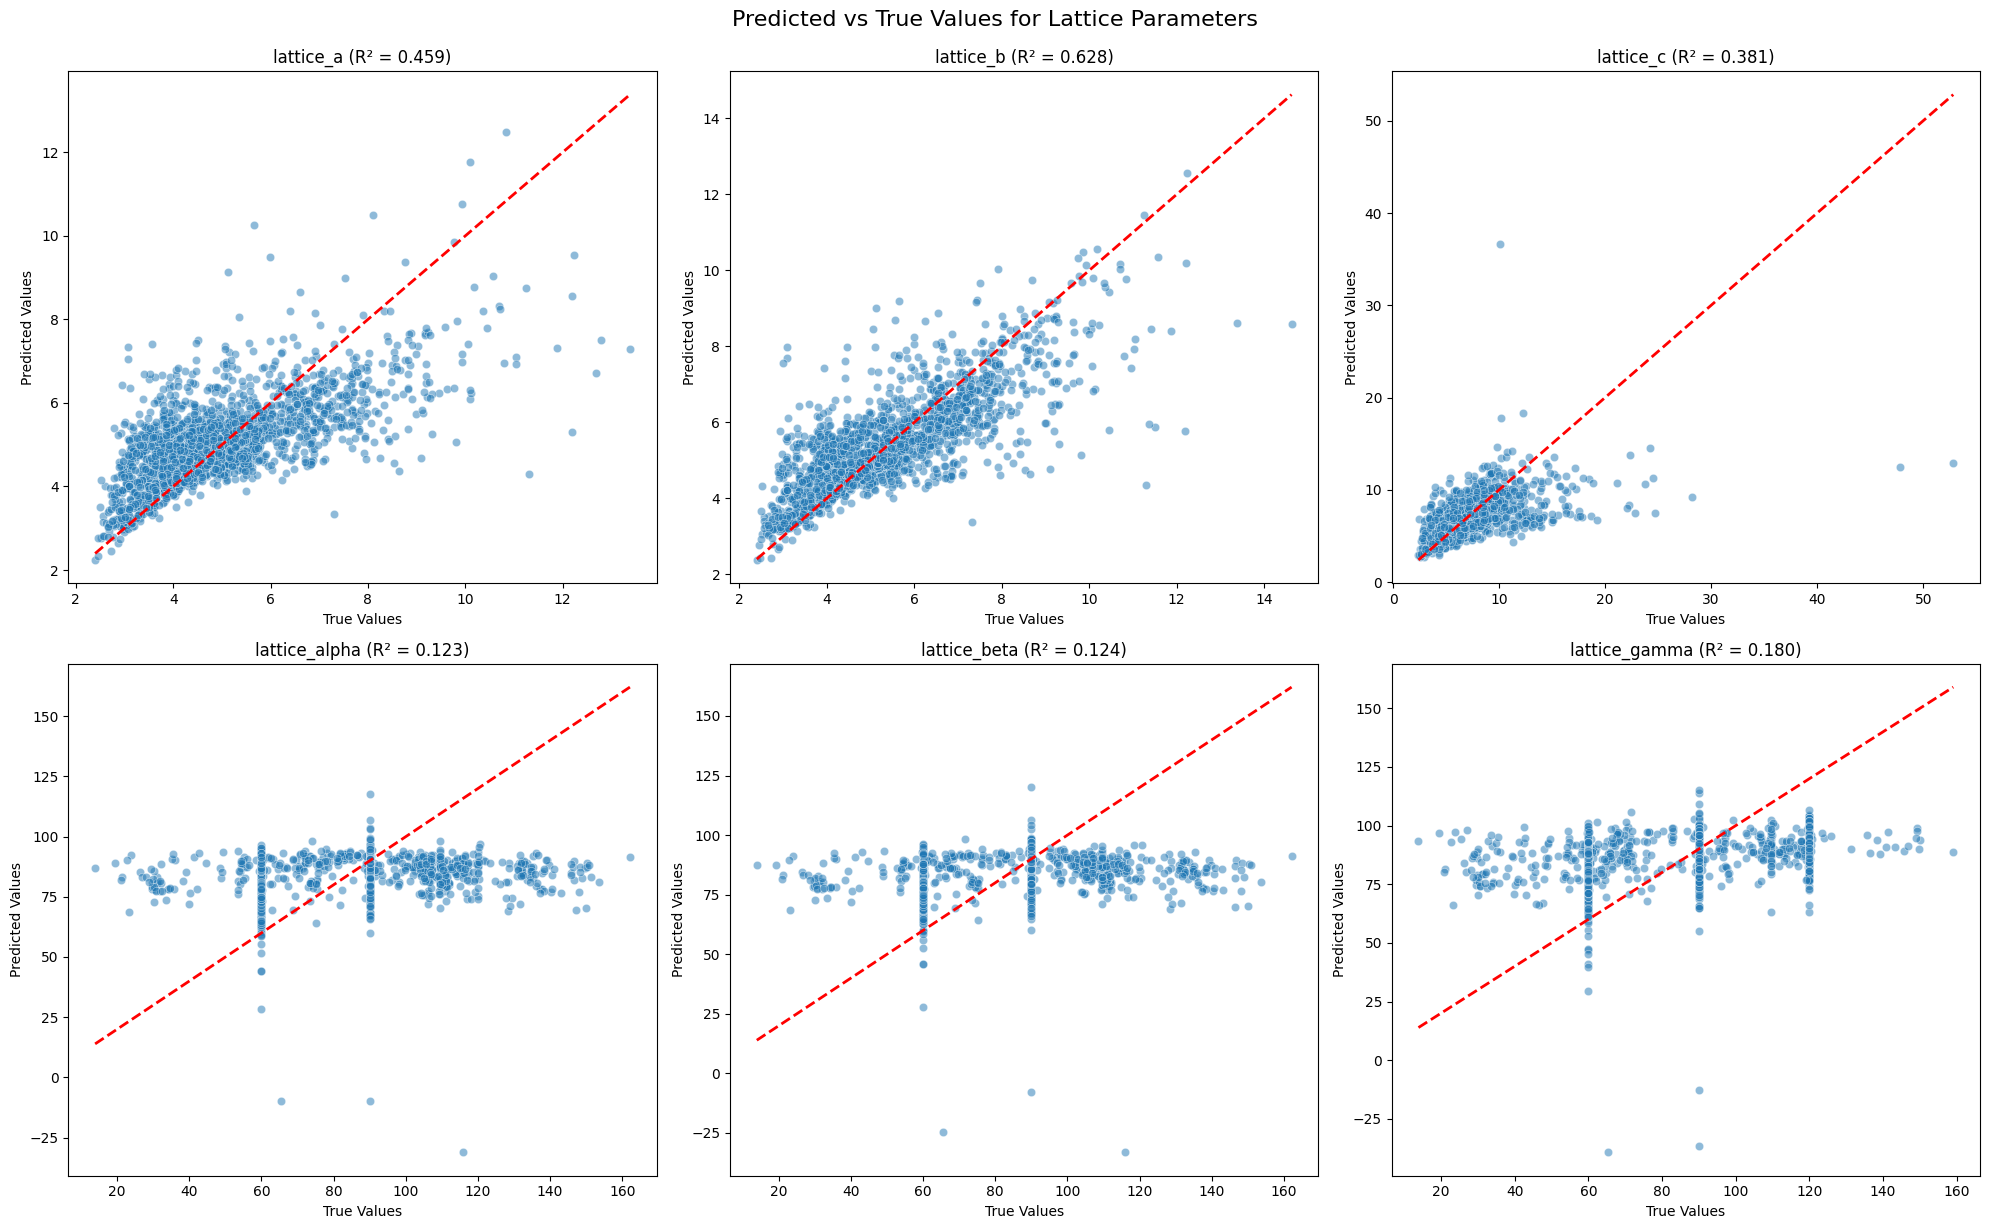

In [ ]:
# Polynomial Regression Using Best Parameters from Previous Search

X_train_Poly2, X_test_Poly2, Y_train_Poly2, Y_test_Poly2 = train_test_split_custom(df_with_lattice)
X_train_scaled_Poly2, X_test_scaled_Poly2, Y_train_aligned_Poly2, Y_test_aligned_Poly2 = scale_and_transform(X_train_Poly2, X_test_Poly2, Y_train_Poly2, Y_test_Poly2)

# Define the base ElasticNet estimator
base_elastic_net2 = ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=10000)  # Use optimized parameters from previous search)

# Polynomial feature transformation
poly2 = PolynomialFeatures(degree=2)  # Change degree for higher polynomials

# Create the pipeline with PolynomialFeatures and MultiOutputRegressor
multi_poly_elastic_net2 = Pipeline([
    ('poly', poly2),
    ('regressor', MultiOutputRegressor(base_elastic_net2))  # Apply ElasticNet to each target
])

multi_poly_elastic_net2.fit(X_train_scaled_Poly2, Y_train_aligned_Poly2)
Y_pred_Poly2 = multi_poly_elastic_net2.predict(X_test_scaled_Poly2)

# Overall evaluation
r2_2 = r2_score(Y_test_aligned_Poly2, Y_pred_Poly2)
mse_2 = mean_squared_error(Y_test_aligned_Poly2, Y_pred_Poly2)

print(f"\nOptimized Polynomial Regression Model Performance:")
print(f"R² = {r2_2:.3f}")
print(f"MSE = {mse_2:.3f}")

# Evaluate and Plot
evaluate_multioutput_regression(Y_test_aligned_Poly.to_numpy(), Y_pred_Poly, target_names=lattice_features)
plot_multioutput_regression_results(Y_test_aligned_Poly.to_numpy(), Y_pred_Poly, target_names=lattice_features)
